In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/got-dataset/cancion_hielo_fuego_corpus.txt


In [6]:
# ============================================
# CELDA 1: INSTALACIÓN DE DEPENDENCIAS
# ============================================
!pip install torch numpy matplotlib minisom scikit-learn tqdm imageio imageio-ffmpeg --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import re
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
import warnings
import imageio # Para crear GIFs
import glob    # Para encontrar archivos PNG

warnings.filterwarnings('ignore')

print("✓ Dependencias instaladas (imageio añadido)")



✓ Dependencias instaladas (imageio añadido)


In [7]:
# ============================================
# CELDA 2: CONFIGURACIÓN Y DISPOSITIVO
# ============================================
# Configuración del dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {DEVICE}")

# Configuración del proyecto
CORPUS_PATH = "/kaggle/input/got-dataset/cancion_hielo_fuego_corpus.txt"
MODEL_SAVE_PATH = "lstm_som_spanish.pth"

# Hiperparámetros del modelo LSTM
EMBEDDING_DIM = 128    # Dimensión de embeddings
HIDDEN_DIM = 256       # Dimensión de estados ocultos LSTM
N_LAYERS = 2           # Número de capas LSTM
DROPOUT = 0.2          # Dropout para regularización
SEQ_LEN = 100          # Longitud de secuencias
BATCH_SIZE = 64        # Tamaño del batch
LEARNING_RATE = 0.001  # Tasa de aprendizaje
EPOCHS = 1            # Número de épocas

# Hiperparámetros del SOM
SOM_X = 20             # Ancho del mapa SOM
SOM_Y = 20             # Alto del mapa SOM
SOM_ITERATIONS = 10000 # Iteraciones de entrenamiento SOM
SOM_SIGMA = 1.5        # Radio de vecindad inicial
SOM_LR = 0.5           # Tasa de aprendizaje SOM

print("✓ Configuración lista")



Dispositivo: cuda
✓ Configuración lista


In [8]:
# ============================================
# CELDA 3: CARGA Y LIMPIEZA DE DATOS
# ============================================
def clean_text(text_input):
    """Limpia el texto eliminando elementos no deseados"""
    print("Limpiando texto...")
    
    lines = text_input.split('\n')
    cleaned_lines = []

    # Patrones a eliminar (más específicos primero)
    # Los patrones que empiezan con ^ y terminan con $ son para líneas completas.
    # re.IGNORECASE es importante.
    patterns_to_remove_entire_line = [
        r"^\s*George R\. R\. Martin\s*$",
        r"^\s*G\s*e\s*o\s*r\s*g\s*e\s*R\s*\.\s*R\s*\.\s*M\s*a\s*r\s*t\s*i\s*n\s*$", # Para "G e o r g e..."
        r"^\s*Canción de Hielo y Fuego\s*(/\s*\d+)?\s*$",
        r"^\s*Juego de Tronos\s*$",
        r"^\s*J\s*u\s*e\s*g\s*o\s*d\s*e\s*t\s*r\s*o\s*n\s*o\s*s\s*$", # Para "J u e g o..."
        r"^\s*Choque de Reyes\s*$",
        r"^\s*Tormenta de Espadas\s*$",
        r"^\s*Festín de Cuervos\s*$",
        r"^\s*Danza de Dragones\s*$",
        r"^\s*Fuego y Sangre\s*$",
        r"^\s*(PRÓLOGO|EPÍLOGO|APÉNDICE)\s*$",
        r"^\s*CAPÍTULO\s*([IVXLCDM]+|\d+)\s*$", # Acepta números romanos o arábigos para capítulos
        r"^\s*Página\s*\d+\s*$",
        r"^\s*\d+\s*$", # Líneas que son solo números (posibles números de página)
    ]

    for line_num, line_content in enumerate(lines):
        line_stripped = line_content.strip()
        skip_line = False
        
        if not line_stripped: # Saltar líneas completamente vacías (después de strip)
            continue

        for pattern_str in patterns_to_remove_entire_line:
            if re.fullmatch(pattern_str, line_stripped, re.IGNORECASE): # re.fullmatch para la línea entera
                skip_line = True
                break
        
        if not skip_line:
            cleaned_lines.append(line_content)
    
    text_processed = "\n".join(cleaned_lines)
    
    text_processed = re.sub(r'[ \t]+', ' ', text_processed)
    text_processed = "\n".join([line.strip() for line in text_processed.split('\n')])
    text_processed = re.sub(r'\n{3,}', '\n\n', text_processed)
    text_processed = "\n".join([line for line in text_processed.split('\n') if line.strip()])

    return text_processed.strip()

# Cargar corpus
try:
    with open(CORPUS_PATH, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    print(f"Corpus cargado: {len(raw_text):,} caracteres")
    
    # Limpiar
    text = clean_text(raw_text)
    print(f"Texto limpio: {len(text):,} caracteres")
    
    # Muestra
    print("\n--- Muestra del texto limpio (primeros 1000 caracteres) ---")
    print(text[:1000])
    print("--- Fin de la muestra ---")
    
    # Muestra del final del texto para buscar créditos, etc.
    if len(text) > 2000:
        print("\n--- Muestra del FINAL del texto limpio (últimos 1000 caracteres) ---")
        print(text[-1000:])
        print("--- Fin de la muestra final ---")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {CORPUS_PATH}")
    print("Usando texto de ejemplo...")
    text = """El invierno se acerca. Los vientos del norte soplan con fuerza.
    Jon Nieve observaba el Muro, pensando en los peligros que acechaban más allá.
    Los caminantes blancos habían regresado después de miles de años.""" * 100

Corpus cargado: 10,961,273 caracteres
Limpiando texto...
Texto limpio: 10,914,088 caracteres

--- Muestra del texto limpio (primeros 1000 caracteres) ---
—Deberíamos volver ya —instó Gared mientras los bosques se tornaban más y más oscuros a
su alrededor—. Los salvajes están muertos.
—¿Te dan miedo los muertos? —preguntó Ser Waymar Royce, insinuando apenas una
sonrisa.
—Los muertos están muertos —contestó Gared. No había mordido el anzuelo. Era un anciano
de más de cincuenta años, y había visto ir y venir a muchos jóvenes señores—. No tenemos nada
que tratar con ellos.
—¿Y de veras están muertos? —preguntó Royce delicadamente—. ¿Qué prueba tenemos?
—Will los vio —respondió Gared—. Si él dice que están muertos, no necesito más pruebas.
—Mi madre me dijo que los muertos no cantan canciones —intervino Will. Sabía que lo iban a
meter en la disputa tarde o temprano. Le habría gustado que fuera más tarde que temprano.
—Mi ama de cría me dijo lo mismo, Will —replicó Royce—. Nunca creas nada d

In [9]:
# ============================================
# CELDA 4: TOKENIZACIÓN Y VOCABULARIO
# ============================================
# Crear vocabulario de caracteres
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"\nVocabulario: {vocab_size} caracteres únicos")

# Crear mapeos
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Funciones de codificación
def encode(text):
    return [char_to_idx[ch] for ch in text if ch in char_to_idx]

def decode(indices):
    return ''.join([idx_to_char[idx] for idx in indices])

# Tokenizar todo el texto
data = torch.tensor(encode(text), dtype=torch.long)
print(f"Datos tokenizados: {data.shape[0]:,} tokens")



# ============================================
# CELDA 5: DATASET Y DATALOADER
# ============================================
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return x, y

# División train/val
n_train = int(0.9 * len(data))
train_data = data[:n_train]
val_data = data[n_train:]

# Crear datasets
train_dataset = CharDataset(train_data, SEQ_LEN)
val_dataset = CharDataset(val_data, SEQ_LEN)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDatasets creados:")
print(f"Train: {len(train_dataset):,} secuencias")
print(f"Val: {len(val_dataset):,} secuencias")



Vocabulario: 116 caracteres únicos
Datos tokenizados: 10,914,088 tokens

Datasets creados:
Train: 9,822,579 secuencias
Val: 1,091,309 secuencias


In [10]:
# ============================================
# CELDA 6: MODELO LSTM
# ============================================
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Capas
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        # Inicialización
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        batch_size = x.size(0)
        
        # Embedding
        embeds = self.embedding(x)  # (batch, seq_len, embedding_dim)
        
        # LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)  # (batch, seq_len, hidden_dim)
        
        # Dropout y salida
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)  # (batch, seq_len, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # Inicializar estados ocultos
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(DEVICE)
        return (h0, c0)
    
    def get_embeddings(self):
        """Obtener embeddings para análisis con SOM"""
        return self.embedding.weight.detach().cpu().numpy()
    
    def get_hidden_states(self, x):
        """Obtener estados ocultos para análisis con SOM"""
        with torch.no_grad():
            batch_size = x.size(0)
            hidden = self.init_hidden(batch_size)
            embeds = self.embedding(x)
            lstm_out, (h_n, c_n) = self.lstm(embeds, hidden)
            return lstm_out.cpu().numpy(), h_n.cpu().numpy()

# Crear modelo
model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

print(f"\nModelo LSTM creado:")
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")



Modelo LSTM creado:
Parámetros totales: 966,260


In [11]:
# ============================================
# CELDA 7: ENTRENAMIENTO (CON SOMs DINÁMICOS)
# ============================================
def train_epoch(model, loader, optimizer, criterion): # Tu función existente
    model.train()
    total_loss = 0
    
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training", leave=False)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        hidden = model.init_hidden(x.size(0))
        output, hidden = model(x, hidden)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion): # Tu función existente
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            hidden = model.init_hidden(x.size(0))
            output, hidden = model(x, hidden)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

# --- INICIO: Función para SOMs Dinámicos (Modificada) ---
def train_and_save_som_visualization(data_for_som, som_x, som_y, input_dim, sigma, lr, iterations, 
                                     title_prefix, epoch_num, output_dir="som_evolution", 
                                     labels_for_som=None, char_font_size=7, max_labels_to_plot=40): # Ajusta char_font_size y max_labels
    """
    Entrena un SOM, guarda su U-Matrix y opcionalmente etiqueta algunos nodos.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    som = MiniSom(som_x, som_y, input_dim, sigma=sigma, learning_rate=lr,
                  neighborhood_function='gaussian', random_seed=42)
    
    data_copy = np.copy(data_for_som) # Asegurar que sea C-contiguo si es necesario
    
    # Intentar inicialización con PCA, si falla, usar aleatoria
    if data_copy.ndim == 2 and data_copy.shape[0] > data_copy.shape[1] and data_copy.shape[0] > 1:
        try:
            som.pca_weights_init(data_copy)
        except Exception as e:
            print(f"  Advertencia: PCA init falló para {title_prefix} (Epoch {epoch_num}): {e}. Usando random_weights_init.")
            som.random_weights_init(data_copy)
    else:
        # print(f"  Advertencia: No suficientes muestras o dimensiones incorrectas ({data_copy.shape}) para PCA init en {title_prefix} (Epoch {epoch_num}). Usando random_weights_init.")
        som.random_weights_init(data_copy)

    som.train_random(data_copy, iterations, verbose=False)

    plt.figure(figsize=(10, 9)) # Ligeramente más grande para etiquetas
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.pcolor(som.distance_map().T, cmap='bone_r')
    plt.colorbar(label='Distancia entre neuronas')
    plt.title(f'{title_prefix} - Epoch {epoch_num}', fontsize=12)
    
    if labels_for_som is not None and len(labels_for_som) == data_for_som.shape[0]:
        # Para etiquetar, obtener las posiciones BMU para una muestra de las etiquetas
        # Esto evita sobrecargar el gráfico si hay muchos caracteres en la misma celda
        # y ayuda a que las etiquetas no se superpongan tanto.
        
        # Mapear cada etiqueta a su BMU
        bmu_map = defaultdict(list)
        for i, label in enumerate(labels_for_som):
            w = som.winner(data_copy[i])
            bmu_map[w].append(label)
        
        # Iterar sobre las neuronas del SOM y etiquetar
        for (x_coord, y_coord), mapped_labels in bmu_map.items():
            # Si hay muchas etiquetas en una neurona, mostrar solo algunas
            display_label = ",".join(mapped_labels[:3]) # Mostrar hasta 3 etiquetas por neurona
            if len(mapped_labels) > 3:
                display_label += "..."
            
            plt.text(x_coord + 0.5, y_coord + 0.5, display_label,
                     ha='center', va='center', fontsize=char_font_size,
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='wheat', alpha=0.6, lw=0.5))

    plt.xticks(np.arange(0, som_x + 1, step=max(1, som_x//10)), fontsize=9) # Ajustar ticks
    plt.yticks(np.arange(0, som_y + 1, step=max(1, som_y//10)), fontsize=9)
    plt.xlim([0, som_x])
    plt.ylim([0, som_y])
    plt.tight_layout() # Añadido para mejorar espaciado
    
    filename = f"{title_prefix.lower().replace(' ', '_').replace('/','_')}_epoch_{epoch_num:03d}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=120) # Aumentar dpi para mejor calidad de imagen
    plt.close()
    print(f"  SOM guardado: {filepath}")

# --- FIN: Función para SOMs Dinámicos ---

# Configurar entrenamiento (Igual que antes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

# Entrenar
print("\nEntrenando modelo LSTM y SOMs dinámicos...")
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Hiperparámetros para SOMs dinámicos (Igual que antes, pero puedes ajustar EPOCHS aquí para pruebas)
# EPOCHS = 1 # <--- DESCOMENTA Y CAMBIA ESTO PARA PRUEBAS RÁPIDAS
SOM_UPDATE_FREQUENCY = 5 
DYNAMIC_SOM_ITERATIONS = 3000

# Preparar una muestra FIJA de datos para los estados ocultos del SOM dinámico (Igual que antes)
fixed_sample_size_for_som = BATCH_SIZE * 5 
if len(val_dataset) >= fixed_sample_size_for_som:
    subset_indices = np.random.choice(len(val_dataset), fixed_sample_size_for_som, replace=False)
    fixed_val_subset = torch.utils.data.Subset(val_dataset, subset_indices)
    fixed_val_loader_for_som = DataLoader(fixed_val_subset, batch_size=BATCH_SIZE)
else: 
    fixed_val_loader_for_som = DataLoader(val_dataset, batch_size=BATCH_SIZE) # Usar todo val si es pequeño

print(f"Usando {len(fixed_val_loader_for_som.dataset)} muestras fijas de validación para SOM de estados ocultos.")

# Crear directorios para guardar las imágenes de los SOMs (Igual que antes)
som_embeddings_dir = "som_evolution_embeddings"
som_hidden_dir = "som_evolution_hidden"
if not os.path.exists(som_embeddings_dir): os.makedirs(som_embeddings_dir)
if not os.path.exists(som_hidden_dir): os.makedirs(som_hidden_dir)


for epoch in range(1, EPOCHS + 1): # Asegúrate que EPOCHS esté definido (Celda 2)
    print(f"\n--- Iniciando Epoch {epoch}/{EPOCHS} ---")
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        print(f"Nueva mejor Val Loss: {val_loss:.4f} (anterior: {best_val_loss:.4f}). Guardando modelo...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # --- INICIO: Lógica SOM Dinámico (Opción de estados ocultos modificada) ---
    if epoch == 1 or epoch % SOM_UPDATE_FREQUENCY == 0 or epoch == EPOCHS:
        print(f"  --- Actualizando SOMs para la Época {epoch} ---")
        
        model.eval() 
        current_embeddings = model.get_embeddings()
        
        train_and_save_som_visualization(
            current_embeddings, SOM_X, SOM_Y, EMBEDDING_DIM,
            SOM_SIGMA, SOM_LR, DYNAMIC_SOM_ITERATIONS,
            "SOM Embeddings", epoch, output_dir=som_embeddings_dir,
            labels_for_som=chars 
        )
        
        print("  Extrayendo estados ocultos para SOM dinámico...")
        temp_hidden_states_list = []
        with torch.no_grad():
            for x_fixed_batch, _ in fixed_val_loader_for_som: 
                x_fixed_batch = x_fixed_batch.to(DEVICE)
                lstm_out_current, _ = model.get_hidden_states(x_fixed_batch) # (batch, seq_len, hidden_dim)
                
                # OPCIÓN MODIFICADA: Tomar TODOS los estados ocultos de la secuencia, no solo el último
                # Esto dará BATCH_SIZE * SEQ_LEN vectores de estado oculto por batch
                # Puede hacer el SOM más rico pero también más costoso de entrenar.
                # Si es demasiado, vuelve a lstm_out_current[:, -1, :]
                reshaped_lstm_out = lstm_out_current.reshape(-1, HIDDEN_DIM) 
                temp_hidden_states_list.append(reshaped_lstm_out) 
        
        if temp_hidden_states_list:
            current_hidden_states_sample = np.concatenate(temp_hidden_states_list, axis=0)
             # Muestrear si es demasiado grande para el SOM dinámico
            if current_hidden_states_sample.shape[0] > 15000: # Límite arbitrario
                print(f"  Muestreando {15000} estados ocultos de {current_hidden_states_sample.shape[0]} para SOM...")
                sample_indices = np.random.choice(current_hidden_states_sample.shape[0], 15000, replace=False)
                current_hidden_states_sample = current_hidden_states_sample[sample_indices]

            model.train() # Volver a modo train ANTES de llamar a la función SOM si esta usa el modelo
            
            train_and_save_som_visualization(
                current_hidden_states_sample, SOM_X, SOM_Y, HIDDEN_DIM,
                SOM_SIGMA, SOM_LR, DYNAMIC_SOM_ITERATIONS,
                "SOM Estados Ocultos", epoch, output_dir=som_hidden_dir
            )
        else:
            print("  No se pudieron extraer estados ocultos para el SOM dinámico.")
        
        model.train() # Asegurarse de que siempre volvemos a modo train
    # --- FIN: Lógica SOM Dinámico ---

print("\n✓ Entrenamiento completado")
print(f"Mejor Val Loss obtenida: {best_val_loss:.4f}")


Entrenando modelo LSTM y SOMs dinámicos...
Usando 320 muestras fijas de validación para SOM de estados ocultos.

--- Iniciando Epoch 1/1 ---


Nueva mejor Val Loss: 1.2812 (anterior: inf). Guardando modelo...
Epoch 1/1 - Train Loss: 1.2212, Val Loss: 1.2812, LR: 0.001000
  --- Actualizando SOMs para la Época 1 ---
  SOM guardado: som_evolution_embeddings/som_embeddings_epoch_001.png
  Extrayendo estados ocultos para SOM dinámico...
  Muestreando 15000 estados ocultos de 32000 para SOM...
  SOM guardado: som_evolution_hidden/som_estados_ocultos_epoch_001.png

✓ Entrenamiento completado
Mejor Val Loss obtenida: 1.2812


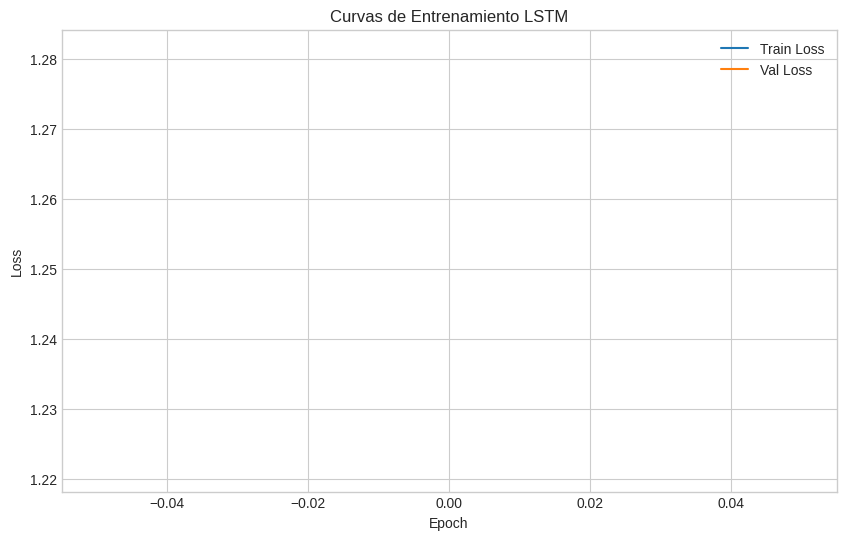

In [12]:
# ============================================
# CELDA 8: VISUALIZACIÓN DEL ENTRENAMIENTO
# ============================================
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curvas de Entrenamiento LSTM')
plt.legend()
plt.grid(True)
plt.show()

In [13]:

# ============================================
# CELDA 9: GENERACIÓN DE TEXTO
# ============================================
def generate_text(model, start_text, length=500, temperature=0.8):
    model.eval()
    
    # Preparar entrada
    chars_idx = encode(start_text)
    if not chars_idx:
        chars_idx = [0]  # Carácter por defecto
    
    input_seq = torch.tensor(chars_idx, dtype=torch.long).unsqueeze(0).to(DEVICE)
    hidden = model.init_hidden(1)
    
    generated = list(chars_idx)
    
    with torch.no_grad():
        for _ in range(length):
            # Predecir
            output, hidden = model(input_seq, hidden)
            
            # Aplicar temperatura
            output = output[0, -1, :] / temperature
            probs = torch.softmax(output, dim=0)
            
            # Muestrear
            idx = torch.multinomial(probs, 1).item()
            generated.append(idx)
            
            # Preparar siguiente entrada
            input_seq = torch.tensor([[idx]], dtype=torch.long).to(DEVICE)
    
    return decode(generated)

# Cargar mejor modelo
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Generar muestras
print("\n=== GENERACIÓN DE TEXTO ===")
prompts = ["El invierno", "Jon Nieve", "Los dragones", "La batalla", "Tyrion"]

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 50)
    generated = generate_text(model, prompt, length=300, temperature=0.7)
    print(generated)


=== GENERACIÓN DE TEXTO ===

Prompt: 'El invierno'
--------------------------------------------------
El invierno le prestó a la cabeza y en la puerta de Lyanna y le pareció
que la mujer hacía que la voz de ella colgaban de cortesía a la capa de luz.
«Por supuesto —ordenó Lord Beric en los puntos que había conseguido del pasado. No llevaba una palabra de barro seco.
—La chica ha sido muy galante —dijo Jon Niev

Prompt: 'Jon Nieve'
--------------------------------------------------
Jon Nieve; parecía que había que hablar las
canciones. La oscuridad de la cabeza de Bran y la sangre de
un caballo era una galera mercante y la tierra de su mano hasta que se le resultaba apenas un salto a la mano. La
lengua con la antorcha contempló la cabeza para contemplar el torreón y la antorcha se acor

Prompt: 'Los dragones'
--------------------------------------------------
Los dragones conseguían estar con cariño con un paso con final largas y
con las manos con toda la ropa, y no estaba llena de des

In [14]:
# ============================================
# CELDA 10: EXTRACCIÓN DE REPRESENTACIONES
# ============================================
print("\n=== EXTRACCIÓN DE REPRESENTACIONES PARA SOM ===")

# 1. Extraer embeddings de caracteres
char_embeddings = model.get_embeddings()
print(f"Embeddings shape: {char_embeddings.shape}")

# 2. Extraer estados ocultos de secuencias
hidden_states_list = []
hidden_states_labels = []

# Tomar muestras del dataset
n_samples = 1000
sample_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

print("Extrayendo estados ocultos...")
for i, (x, y) in enumerate(sample_loader):
    if i >= n_samples:
        break
    
    x = x.to(DEVICE)
    lstm_out, h_n = model.get_hidden_states(x)
    
    # Usar el último estado oculto
    hidden_state = lstm_out[0, -1, :]  # (hidden_dim,)
    hidden_states_list.append(hidden_state)
    
    # Guardar el texto correspondiente para análisis
    text_seq = decode(x[0].cpu().numpy())
    hidden_states_labels.append(text_seq[-10:])  # Últimos 10 caracteres

hidden_states_array = np.array(hidden_states_list)
print(f"Estados ocultos shape: {hidden_states_array.shape}")



=== EXTRACCIÓN DE REPRESENTACIONES PARA SOM ===
Embeddings shape: (116, 128)
Extrayendo estados ocultos...
Estados ocultos shape: (1000, 256)



=== ENTRENAMIENTO SOM PARA EMBEDDINGS ===
Entrenando SOM...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.34738243624591075


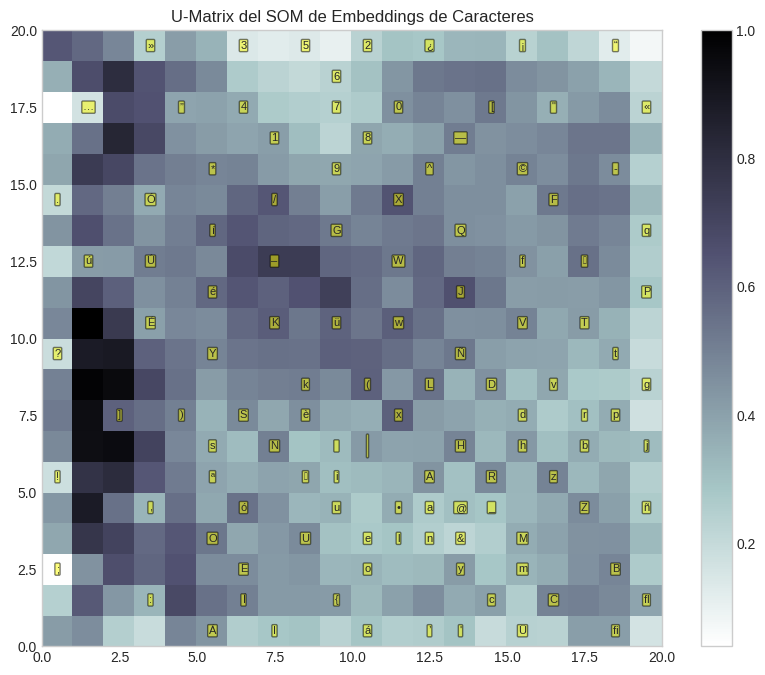


Análisis de clusters en embeddings:


In [15]:
# ============================================
# CELDA 11: ENTRENAMIENTO DE SOM PARA EMBEDDINGS
# ============================================
print("\n=== ENTRENAMIENTO SOM PARA EMBEDDINGS ===")

# Crear y entrenar SOM para embeddings
som_embeddings = MiniSom(
    SOM_X, SOM_Y, 
    EMBEDDING_DIM,
    sigma=SOM_SIGMA, 
    learning_rate=SOM_LR,
    neighborhood_function='gaussian',
    random_seed=42
)

# Inicialización con PCA
som_embeddings.pca_weights_init(char_embeddings)

# Entrenar
print("Entrenando SOM...")
som_embeddings.train_random(char_embeddings, SOM_ITERATIONS, verbose=True)

# Visualizar U-Matrix
plt.figure(figsize=(10, 8))
plt.pcolor(som_embeddings.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('U-Matrix del SOM de Embeddings de Caracteres')

# Mapear caracteres a posiciones en el SOM
for i, char in enumerate(chars):
    w = som_embeddings.winner(char_embeddings[i])
    plt.text(w[0]+0.5, w[1]+0.5, char, 
             ha='center', va='center', 
             fontsize=8, 
             bbox=dict(boxstyle='round,pad=0.1', facecolor='yellow', alpha=0.5))

plt.xlim([0, SOM_X])
plt.ylim([0, SOM_Y])
plt.show()

# Análisis de clusters
print("\nAnálisis de clusters en embeddings:")
# Encontrar caracteres similares
char_clusters = defaultdict(list)
for i, char in enumerate(chars):
    w = som_embeddings.winner(char_embeddings[i])
    char_clusters[w].append(char)

# Mostrar clusters con más de un carácter
for pos, chars_in_cluster in char_clusters.items():
    if len(chars_in_cluster) > 1:
        print(f"Posición {pos}: {''.join(chars_in_cluster)}")



=== ENTRENAMIENTO SOM PARA ESTADOS OCULTOS ===
Entrenando SOM para estados ocultos...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.607609611017704


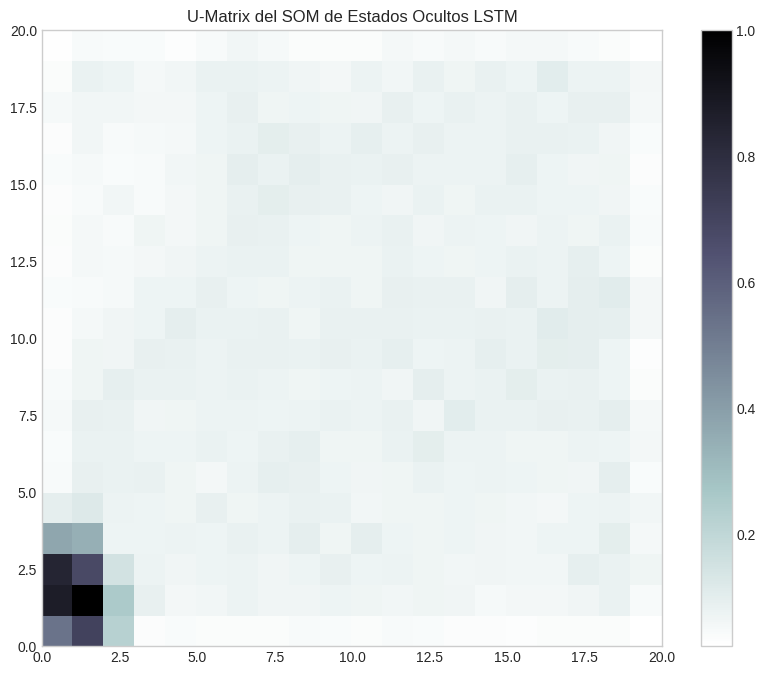

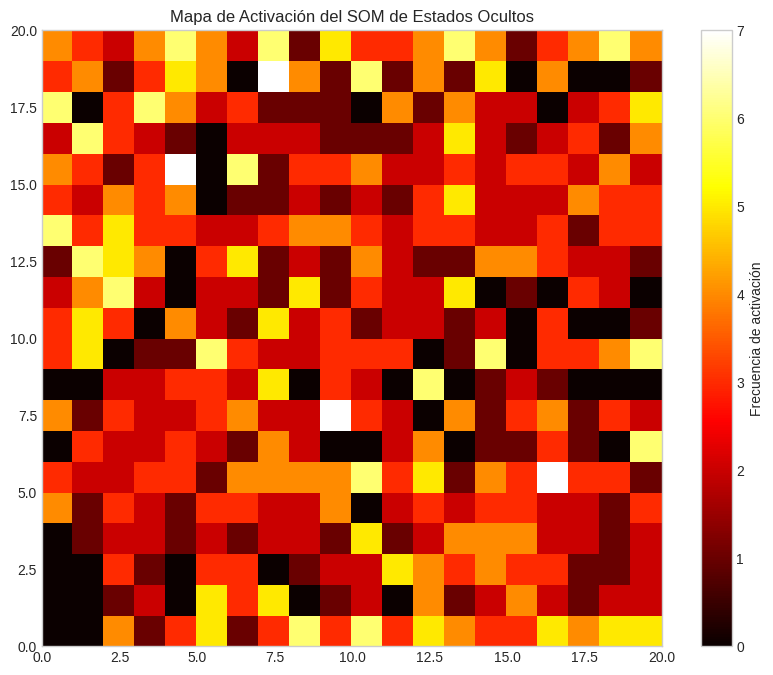

In [16]:
# ============================================
# CELDA 12: SOM PARA ESTADOS OCULTOS
# ============================================
print("\n=== ENTRENAMIENTO SOM PARA ESTADOS OCULTOS ===")

# Crear y entrenar SOM para estados ocultos
som_hidden = MiniSom(
    SOM_X, SOM_Y,
    HIDDEN_DIM,
    sigma=SOM_SIGMA,
    learning_rate=SOM_LR,
    neighborhood_function='gaussian',
    random_seed=42
)

# Inicialización y entrenamiento
som_hidden.pca_weights_init(hidden_states_array)
print("Entrenando SOM para estados ocultos...")
som_hidden.train_random(hidden_states_array, SOM_ITERATIONS, verbose=True)

# Visualizar U-Matrix
plt.figure(figsize=(10, 8))
plt.pcolor(som_hidden.distance_map().T, cmap='bone_r')
plt.colorbar()
plt.title('U-Matrix del SOM de Estados Ocultos LSTM')
plt.show()

# Análisis de activación
activation_map = np.zeros((SOM_X, SOM_Y))
for hidden_state in hidden_states_array:
    w = som_hidden.winner(hidden_state)
    activation_map[w[0], w[1]] += 1

plt.figure(figsize=(10, 8))
plt.pcolor(activation_map.T, cmap='hot')
plt.colorbar(label='Frecuencia de activación')
plt.title('Mapa de Activación del SOM de Estados Ocultos')
plt.show()


=== ANÁLISIS DE INTERPRETABILIDAD MECÁNICA ===


<Figure size 1500x500 with 0 Axes>

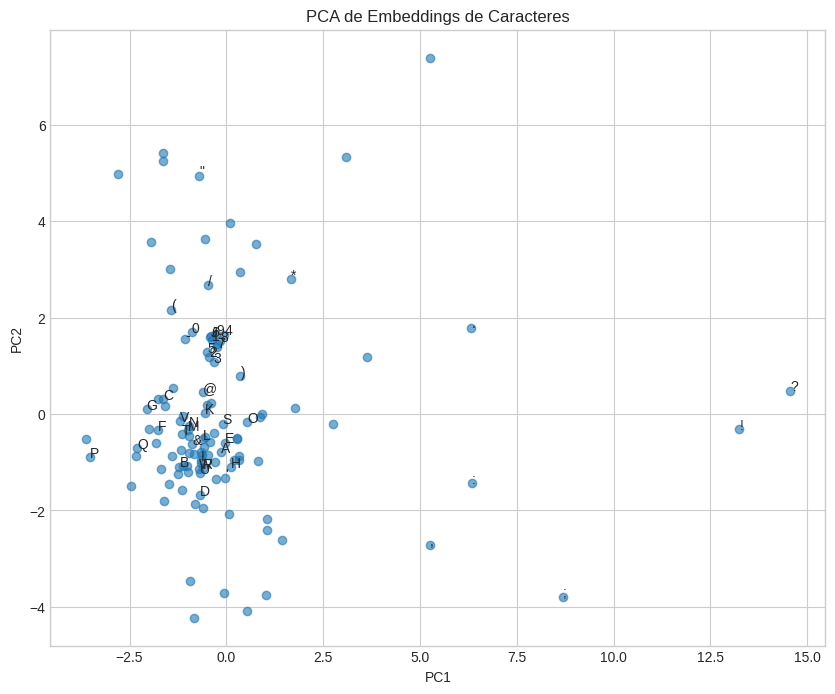

In [17]:
# ============================================
# CELDA 13: ANÁLISIS DE INTERPRETABILIDAD
# ============================================
print("\n=== ANÁLISIS DE INTERPRETABILIDAD MECÁNICA ===")

# 1. Análisis de transiciones en el SOM
def analyze_text_trajectory(text, model, som):
    """Analiza la trayectoria de un texto en el SOM"""
    encoded = encode(text)
    if len(encoded) < SEQ_LEN:
        return None
    
    trajectory = []
    
    for i in range(len(encoded) - SEQ_LEN):
        seq = torch.tensor(encoded[i:i+SEQ_LEN], dtype=torch.long).unsqueeze(0).to(DEVICE)
        lstm_out, _ = model.get_hidden_states(seq)
        hidden_state = lstm_out[0, -1, :]
        winner = som_hidden.winner(hidden_state)
        trajectory.append(winner)
    
    return trajectory

# Analizar diferentes tipos de texto
sample_texts = {
    "Batalla": "La batalla fue feroz. Los soldados luchaban con valentía.",
    "Diálogo": "—¿Dónde está Jon? —preguntó Arya. —No lo sé —respondió Sansa.",
    "Descripción": "El castillo se alzaba imponente sobre la colina nevada.",
}

plt.figure(figsize=(15, 5))
for idx, (text_type, text) in enumerate(sample_texts.items()):
    trajectory = analyze_text_trajectory(text, model, som_hidden)
    if trajectory:
        plt.subplot(1, 3, idx+1)
        x_coords = [p[0] for p in trajectory]
        y_coords = [p[1] for p in trajectory]
        plt.plot(x_coords, y_coords, 'o-', alpha=0.7)
        plt.title(f'Trayectoria: {text_type}')
        plt.xlim(0, SOM_X)
        plt.ylim(0, SOM_Y)
        plt.grid(True)
plt.tight_layout()
plt.show()

# 2. PCA de embeddings
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(char_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.6)
for i, char in enumerate(chars[:50]):  # Solo primeros 50 para claridad
    plt.annotate(char, (embeddings_pca[i, 0], embeddings_pca[i, 1]))
plt.title('PCA de Embeddings de Caracteres')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()



=== ANÁLISIS DE NEURONAS ESPECÍFICAS ===


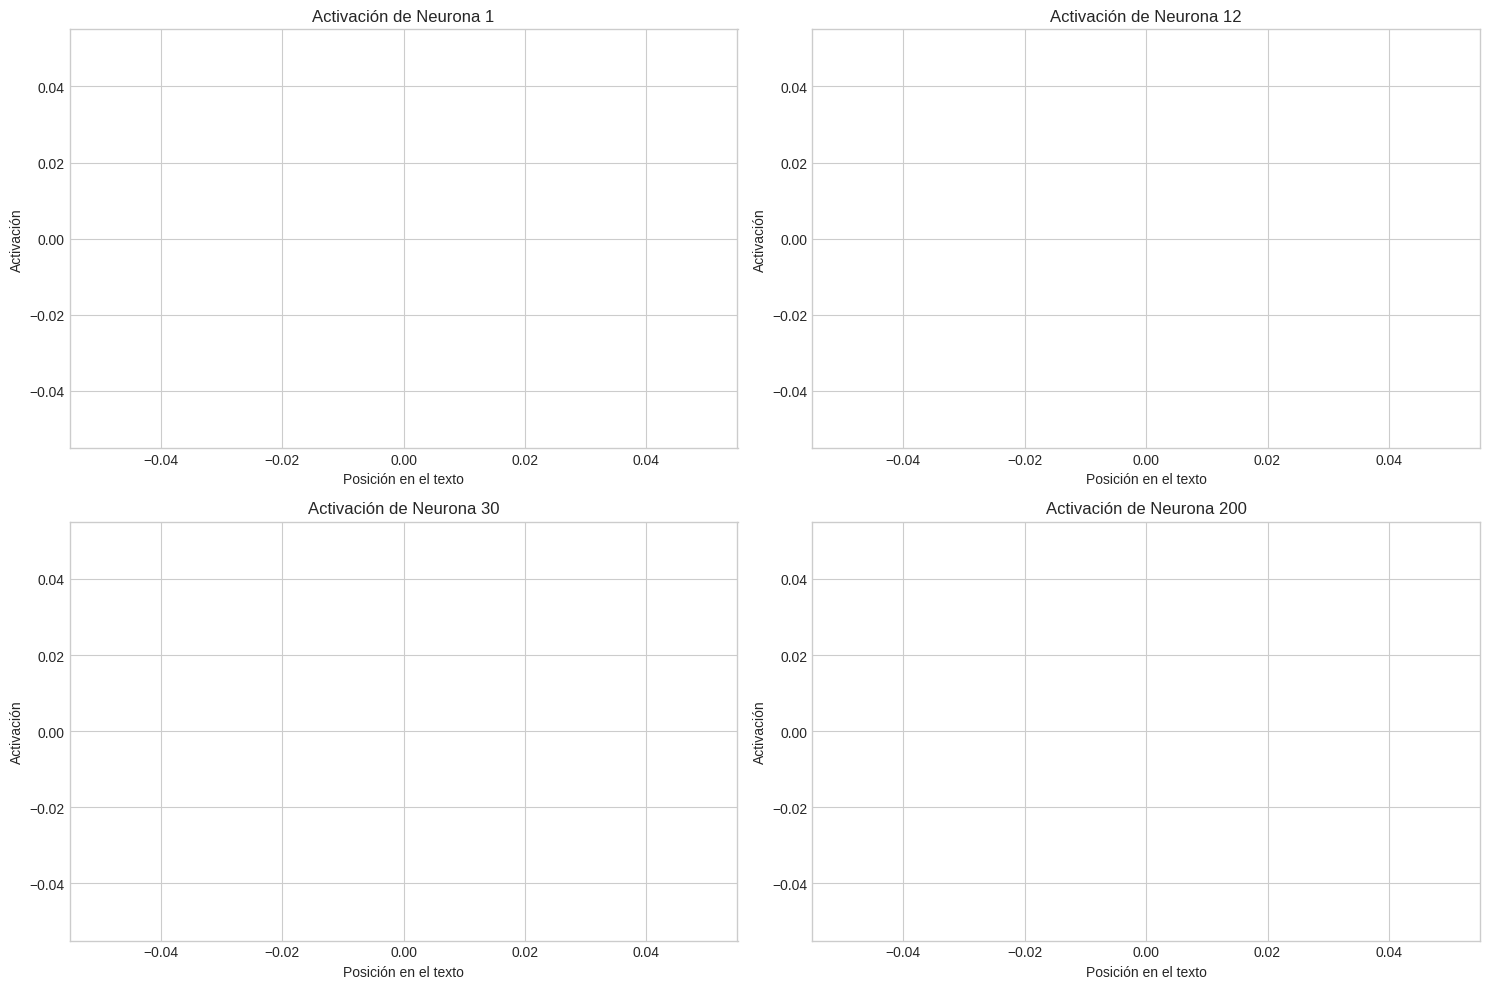

In [23]:
# ============================================
# CELDA 14: ANÁLISIS DE NEURONAS ESPECÍFICAS
# ============================================
print("\n=== ANÁLISIS DE NEURONAS ESPECÍFICAS ===")

def analyze_neuron_activation(model, text, neuron_idx):
    """Analiza la activación de una neurona específica"""
    encoded = encode(text)
    activations = []
    
    for i in range(len(encoded) - SEQ_LEN):
        seq = torch.tensor(encoded[i:i+SEQ_LEN], dtype=torch.long).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            hidden = model.init_hidden(1)
            embeds = model.embedding(seq)
            lstm_out, _ = model.lstm(embeds, hidden)
            activation = lstm_out[0, -1, neuron_idx].item()
            activations.append(activation)
    
    return activations

# Analizar diferentes neuronas
text_sample = text[:1000]
neurons_to_analyze = [1, 12, 30, 200]

plt.figure(figsize=(15, 10))
for idx, neuron_idx in enumerate(neurons_to_analyze):
    activations = analyze_neuron_activation(model, text_sample, neuron_idx)
    
    plt.subplot(2, 2, idx+1)
    plt.plot(activations)
    plt.title(f'Activación de Neurona {neuron_idx}')
    plt.xlabel('Posición en el texto')
    plt.ylabel('Activación')
    plt.grid(True)
plt.tight_layout()
plt.show()



=== RESUMEN DE INTERPRETABILIDAD MECÁNICA ===


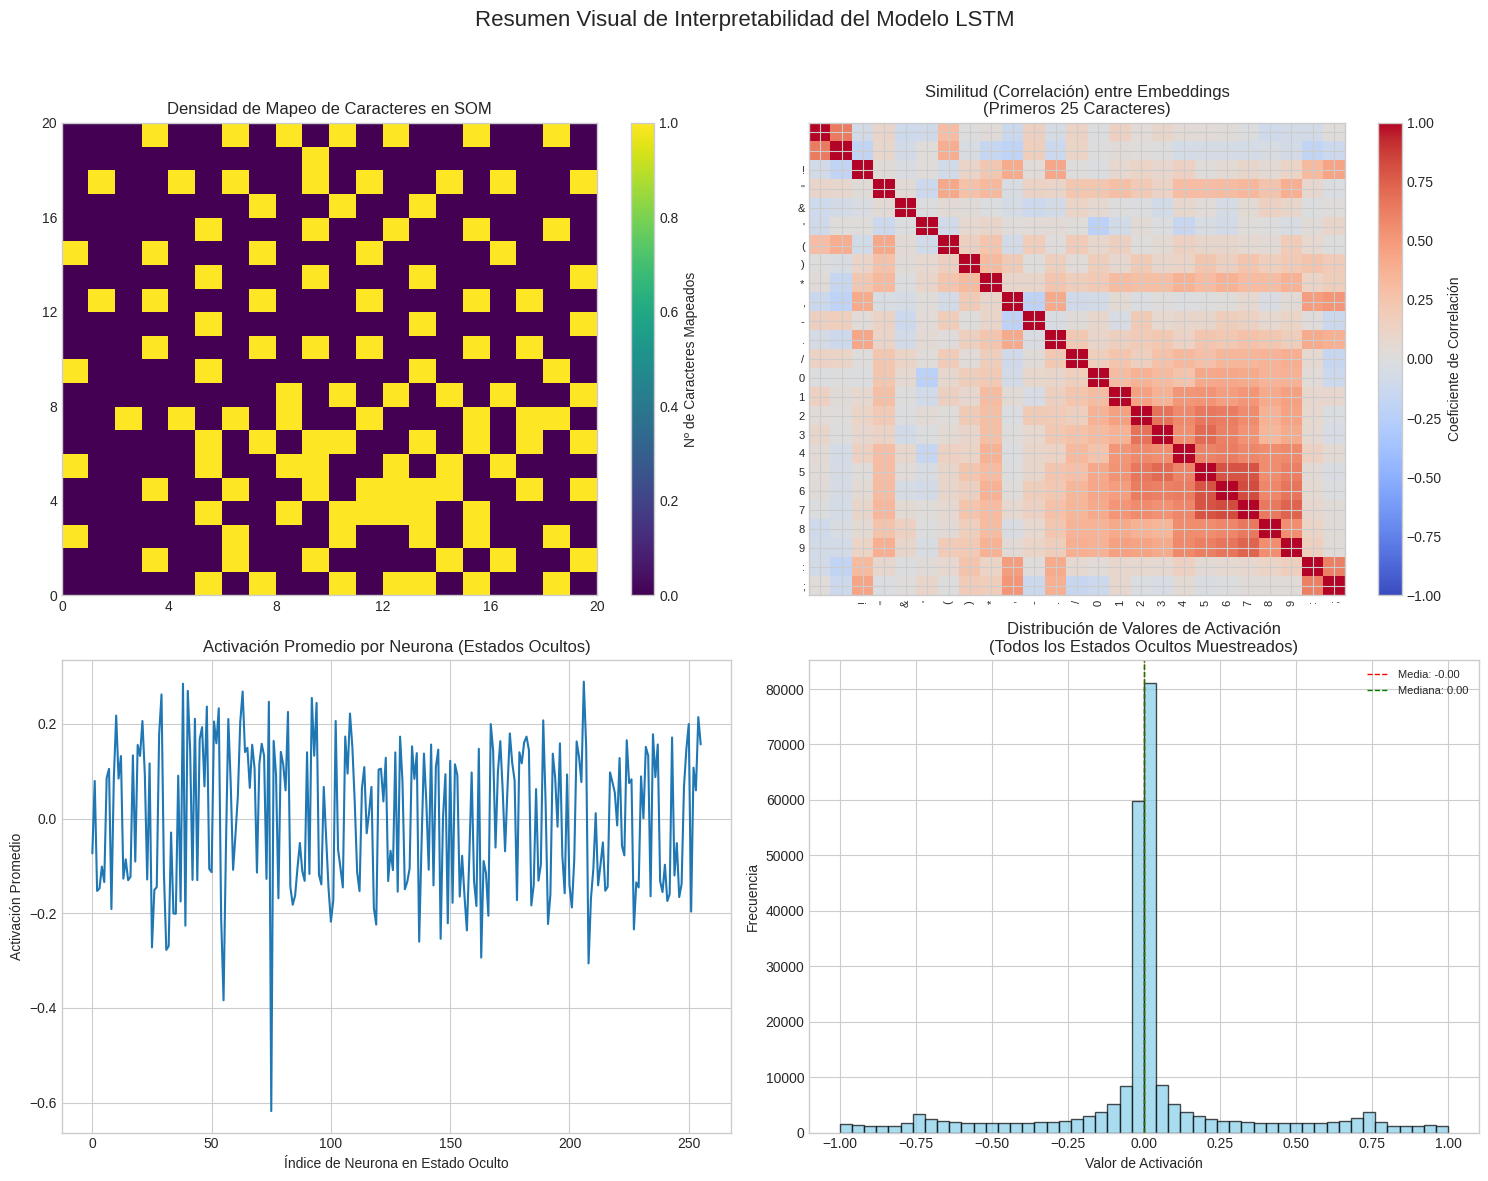


 CONCLUSIONES PRELIMINARES DE INTERPRETABILIDAD (ÉPOCA 1):
1. SOM de Embeddings: Se identificaron 116 neuronas BMU únicas para los caracteres.
   Estas 116 BMUs representan 116 agrupaciones de caracteres (algunas BMUs podrían estar vacías si el SOM es grande).
2. Se espera que los caracteres se agrupen por similitud semántica/fonética a medida que el modelo entrena más.
3. SOM de Estados Ocultos: Los estados ocultos muestreados mapearon a 351 neuronas BMU distintas en el SOM.
4. La red LSTM está en proceso de aprender representaciones estructuradas del español de ASOIAF.
   Con solo 1 época, las estructuras son incipientes. Más épocas revelarán patrones más claros.

✓ Análisis de resumen (Celda 15) completado.


In [20]:
# ============================================
# CELDA 15: VISUALIZACIÓN FINAL Y RESUMEN
# ============================================
print("\n=== RESUMEN DE INTERPRETABILIDAD MECÁNICA ===")

# Crear visualización resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Resumen Visual de Interpretabilidad del Modelo LSTM', fontsize=16)


# 1. Distribución de caracteres en el SOM de Embeddings (Celda 11 ya lo tiene mejor)
#    Aquí podríamos mostrar algo diferente o una versión simplificada.
#    Por ejemplo, la U-Matrix del SOM de embeddings que ya se generó en la Celda 11.
#    O si queremos un mapa de densidad aquí:
ax = axes[0, 0]
if 'som_embeddings' in globals() and 'chars' in globals() and 'char_embeddings' in globals():
    char_density_map = np.zeros((SOM_X, SOM_Y))
    for i, char_emb in enumerate(char_embeddings):
        w = som_embeddings.winner(char_emb)
        char_density_map[w[0], w[1]] += 1
    im_density = ax.pcolor(char_density_map.T, cmap='viridis')
    ax.set_title('Densidad de Mapeo de Caracteres en SOM')
    plt.colorbar(im_density, ax=ax, label='Nº de Caracteres Mapeados')
else:
    ax.text(0.5, 0.5, 'SOM de Embeddings no disponible', ha='center', va='center')
ax.set_xticks(np.arange(0, SOM_X + 1, step=max(1, SOM_X//5)))
ax.set_yticks(np.arange(0, SOM_Y + 1, step=max(1, SOM_Y//5)))


# 2. Similitud entre embeddings (primeros N caracteres para legibilidad)
ax = axes[0, 1]
if 'char_embeddings' in globals() and 'chars' in globals() and len(chars) > 0:
    num_chars_similarity = min(25, len(chars)) # Mostrar para hasta 25 caracteres
    similarity_matrix = np.corrcoef(char_embeddings[:num_chars_similarity])
    im_sim = ax.imshow(similarity_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(num_chars_similarity))
    ax.set_yticks(np.arange(num_chars_similarity))
    ax.set_xticklabels(chars[:num_chars_similarity], rotation=90, fontsize=8)
    ax.set_yticklabels(chars[:num_chars_similarity], fontsize=8)
    ax.set_title(f'Similitud (Correlación) entre Embeddings\n(Primeros {num_chars_similarity} Caracteres)')
    plt.colorbar(im_sim, ax=ax, label='Coeficiente de Correlación')
else:
    ax.text(0.5, 0.5, 'Embeddings no disponibles', ha='center', va='center')

# 3. Activación promedio por neurona en estados ocultos
ax = axes[1, 0]
if 'hidden_states_array' in globals() and hidden_states_array.ndim == 2 and hidden_states_array.shape[0] > 0:
    avg_activation_per_neuron = np.mean(hidden_states_array, axis=0) # Promedio a través de las muestras para cada neurona
    ax.plot(avg_activation_per_neuron)
    ax.set_title('Activación Promedio por Neurona (Estados Ocultos)')
    ax.set_xlabel('Índice de Neurona en Estado Oculto')
    ax.set_ylabel('Activación Promedio')
    ax.grid(True) # Esta era la línea con el error, ahora corregida
else:
    ax.text(0.5, 0.5, 'Estados ocultos no disponibles', ha='center', va='center')


# 4. Distribución de todos los valores de activación en estados ocultos
ax = axes[1, 1]
if 'hidden_states_array' in globals() and hidden_states_array.size > 0:
    ax.hist(hidden_states_array.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title('Distribución de Valores de Activación\n(Todos los Estados Ocultos Muestreados)')
    ax.set_xlabel('Valor de Activación')
    ax.set_ylabel('Frecuencia')
    ax.grid(True)
    ax.axvline(np.mean(hidden_states_array), color='red', linestyle='dashed', linewidth=1, label=f'Media: {np.mean(hidden_states_array):.2f}')
    ax.axvline(np.median(hidden_states_array), color='green', linestyle='dashed', linewidth=1, label=f'Mediana: {np.median(hidden_states_array):.2f}')
    ax.legend(fontsize=8)
else:
    ax.text(0.5, 0.5, 'Estados ocultos no disponibles', ha='center', va='center')


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para el suptitle
plt.show()

# Resumen final en texto
print("\n" + "="*60)
print(" CONCLUSIONES PRELIMINARES DE INTERPRETABILIDAD (ÉPOCA 1):")
print("="*60)

if 'char_clusters' in globals() and char_clusters: # char_clusters se define en Celda 11
    print(f"1. SOM de Embeddings: Se identificaron {len(char_clusters)} neuronas BMU únicas para los caracteres.")
    # Contar cuántos caracteres mapean a la misma BMU (clusters)
    num_actual_clusters = sum(1 for mapped_chars in char_clusters.values() if len(mapped_chars) > 0)
    print(f"   Estas {len(char_clusters)} BMUs representan {num_actual_clusters} agrupaciones de caracteres (algunas BMUs podrían estar vacías si el SOM es grande).")
else:
    print("1. SOM de Embeddings: Análisis de clusters de caracteres no disponible o no ejecutado.")

print(f"2. Se espera que los caracteres se agrupen por similitud semántica/fonética a medida que el modelo entrena más.")

if 'som_hidden' in globals() and 'hidden_states_array' in globals() and hidden_states_array.shape[0] > 0:
    num_distinct_hidden_patterns = len(np.unique([som_hidden.winner(h) for h in hidden_states_array], axis=0))
    print(f"3. SOM de Estados Ocultos: Los estados ocultos muestreados mapearon a {num_distinct_hidden_patterns} neuronas BMU distintas en el SOM.")
else:
    print("3. SOM de Estados Ocultos: Análisis no disponible o no ejecutado.")

print(f"4. La red LSTM está en proceso de aprender representaciones estructuradas del español de ASOIAF.")
print(f"   Con solo 1 época, las estructuras son incipientes. Más épocas revelarán patrones más claros.")
print("\n✓ Análisis de resumen (Celda 15) completado.")


In [22]:
# =======================================================
# CELDA 16: CREAR GIFs DE LA EVOLUCIÓN DE LOS SOMs
# =======================================================
print("\n=== CREANDO GIFs DE EVOLUCIÓN DE SOMs ===")

def create_gif_from_pngs(png_dir, gif_name, duration_per_frame=0.8):
    png_files = sorted(
        glob.glob(os.path.join(png_dir, "*.png")),
        key=lambda x: int(re.search(r"epoch_(\d+)\.png$", x).group(1)) # Ordenar por número de época
    )
    
    if png_files:
        print(f"Encontrados {len(png_files)} PNGs en {png_dir} para el GIF {gif_name}.")
        try:
            with imageio.get_writer(gif_name, mode='I', duration=duration_per_frame, loop=0) as writer:
                for filename in tqdm(png_files, desc=f"Creando {gif_name}"):
                    image = imageio.imread(filename)
                    writer.append_data(image)
            print(f"✓ GIF '{gif_name}' creado exitosamente.")
        except Exception as e:
            print(f"Error creando GIF {gif_name}: {e}")
            print("Asegúrate que imageio y imageio-ffmpeg (o el backend adecuado) estén instalados.")
            print("Puede que necesites instalar ffmpeg en el sistema si no está disponible.")
    else:
        print(f"No se encontraron archivos PNG en {png_dir} para crear el GIF '{gif_name}'.")

# Crear GIF para SOM de Embeddings
create_gif_from_pngs(som_embeddings_dir, "som_embeddings_evolution.gif")

# Crear GIF para SOM de Estados Ocultos
create_gif_from_pngs(som_hidden_dir, "som_hidden_states_evolution.gif")

print("\n✓ Proceso de creación de GIFs finalizado.")
# Los GIFs se guardarán en /kaggle/working/ y podrás descargarlos.


=== CREANDO GIFs DE EVOLUCIÓN DE SOMs ===
Encontrados 1 PNGs en som_evolution_embeddings para el GIF som_embeddings_evolution.gif.


Creando som_embeddings_evolution.gif: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


✓ GIF 'som_embeddings_evolution.gif' creado exitosamente.
Encontrados 1 PNGs en som_evolution_hidden para el GIF som_hidden_states_evolution.gif.


Creando som_hidden_states_evolution.gif: 100%|██████████| 1/1 [00:00<00:00, 46.19it/s]

✓ GIF 'som_hidden_states_evolution.gif' creado exitosamente.

✓ Proceso de creación de GIFs finalizado.
